In [1]:
# import libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pytorch_lightning as pl
from tqdm import tqdm
import yaml

In [2]:
# check the environment
print("Current working directory: ", os.getcwd())
print("OS name: ", sys.platform)
print("Python executable: ", sys.executable)
print("Python version: ", sys.version)
print("PyTorch version: ", torch.__version__)
print("PyTorch Lightning version: ", pl.__version__)
print("CUDA version: ", torch.version.cuda)
print("cuDNN version: ", torch.backends.cudnn.version())
print("Number of GPUs: ", torch.cuda.device_count())
print("GPU model: ", torch.cuda.get_device_name(0))

Current working directory:  /gpfs02/work/akira.tokiwa/gpgpu/Github/SR3D/tests
OS name:  linux
Python executable:  /gpfs02/work/akira.tokiwa/gpgpu/anaconda3/envs/pylit/bin/python
Python version:  3.10.9 (main, Jan 11 2023, 15:21:40) [GCC 11.2.0]
PyTorch version:  2.0.1+cu117
PyTorch Lightning version:  1.9.3
CUDA version:  11.7
cuDNN version:  8500
Number of GPUs:  1
GPU model:  Tesla V100-PCIE-32GB


In [3]:
# import modules
sys.path.append('../')
from scripts.dataloader.data import get_loaders_from_params, get_data_from_params, get_normalized_from_params, get_loaders, Transforms
from scripts.models.Unet_base import Unet
from scripts.diffusion.ddpm import DDPM
from scripts.diffusion.scheduler import TimestepSampler
from scripts.utils.run_utils import setup_trainer, get_parser
from scripts.params import set_params

In [4]:
pl.seed_everything(1234)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

[rank: 0] Global seed set to 1234


In [5]:
def read_hparams(hparams_file):
    with open(hparams_file, 'r') as f:
        hparams = yaml.load(f, Loader=yaml.UnsafeLoader)
    return hparams

In [6]:
#params = read_hparams("/gpfs02/work/akira.tokiwa/gpgpu/Github/SR3D/ckpt_logs/diffusion/HR_sigmoid_linear_concat_b2/version_4/hparams.yaml")
params = read_hparams("/gpfs02/work/akira.tokiwa/gpgpu/Github/SR3D/ckpt_logs/diffusion/HR_sigmoid_linear_concat_b2/version_5/hparams.yaml")
#params = set_params(n_maps=10,use_attn=True,batch_size=4)

In [7]:
params['data']['n_maps'] = 10

In [8]:
### get training data
lr, hr = get_data_from_params(params)
lr, hr = lr.unsqueeze(1)/8, hr.unsqueeze(1)
log2linear_transform = Transforms("log2linear", None, None)
lr, hr = log2linear_transform.inverse_transform(lr), log2linear_transform.inverse_transform(hr)
data_input, data_cond, transforms_input, transforms_cond = get_normalized_from_params(lr, hr, params)
train_loader, val_loader = get_loaders(data_input, data_cond, params["train"]['train_rate'], params["train"]['batch_size'])
print("train:validation = {}:{}, batch_size: {}".format(len(train_loader), len(val_loader), params["train"]['batch_size']))


Loading maps: 100%|██████████| 10/10 [00:00<00:00, 37.46it/s]


LR data loaded from /gpfs02/work/tanimura/ana/UNet/data/dens_magneticum_snap25_Box128_grid32_CIC_noRSD/.  Number of maps: 10
LR data normalized to density field dividing by cube upsample_scale = 8.0


Loading maps: 100%|██████████| 10/10 [00:00<00:00, 27.79it/s]

HR data loaded from /gpfs02/work/tanimura/ana/UNet/data/dens_magneticum_snap25_Box128_grid64_CIC_noRSD/.  Number of maps: 10
LR data normalized to [0.5266004800796509,0.9251978397369385] by sigmoid transform.
HR data normalized to [0.5889384150505066,0.9841253757476807] by sigmoid transform.
train:validation = 4:1, batch_size: 2


In [9]:
#get sampler type
sampler = TimestepSampler(
timesteps=int(params['diffusion']['timesteps']), 
sampler_type=params['diffusion']['sampler_type'])
print("sampler type: {}, timesteps: {}".format(params['diffusion']['sampler_type'], params['diffusion']['timesteps']))

Sampler type uniform


sampler type: uniform, timesteps: 2000


In [10]:
#get model
model = DDPM(Unet, params, sampler = sampler)

We are using Adam with lr = 0.0001, gamma = 0.9999
The schedule is linear with beta_start = 1e-06, beta_end = 0.01


# Generate map

In [12]:
#ckpt_dir = "/gpfs02/work/akira.tokiwa/gpgpu/Github/SR3D/ckpt_logs/diffusion/HR_sigmoid_linear_concat_b2/version_4/checkpoints/Run_12-06-23-59epoch=24-val_loss=0.00.ckpt"
ckpt_dir = "/gpfs02/work/akira.tokiwa/gpgpu/Github/SR3D/ckpt_logs/diffusion/HR_sigmoid_linear_concat_b2/version_5/checkpoints/Run_12-07-00-04epoch=52-val_loss=0.00.ckpt"
#ckpt_dir = params["train"]["save_dir"]+params["train"]["log_name"]+"/version_8/checkpoints/last.ckpt"
model.load_state_dict(torch.load(ckpt_dir)["state_dict"])
model = model.to(device)

In [ ]:
def plot_surface(grid, title=None, save_dir=None):
    surface = np.zeros_like(grid)
    surface[0,:,:] = grid[0,:,:]
    surface[-1,:,:] = grid[-1,:,:]
    surface[:,0,:] = grid[:,0,:]
    surface[:,-1,:] = grid[:,-1,:]
    surface[:,:,0] = grid[:,:,0]
    surface[:,:,-1] = grid[:,:,-1]

    x, y, z = np.where(surface > 0)  # Change 0 to any threshold you want
    values = surface[x, y, z]

    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(x, y, z, c=values, cmap='viridis')
    #fig.colorbar(scatter, ax=ax)
    #ax.set_xlabel('x')
    #ax.set_ylabel('y')
    #ax.set_zlabel('z')
    if title is not None:
        plt.title(title)
    if save_dir is not None:
        plt.savefig(save_dir, dpi=100, bbox_inches='tight')
    else:
        plt.show()

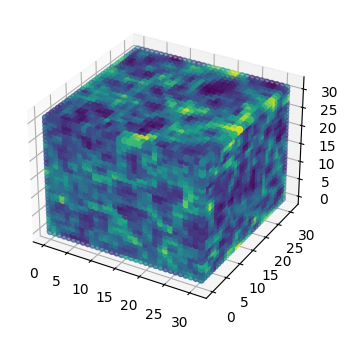

In [28]:
grid = data_cond[:1].squeeze(0).squeeze(0).cpu().numpy()
plot_surface(grid)

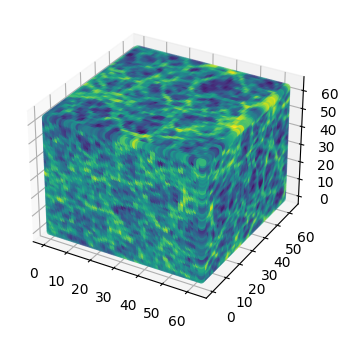

In [27]:
grid = data_input[:1].squeeze(0).squeeze(0).cpu().numpy()
plot_surface(grid)

In [29]:
display_num = 5
random_idx = np.sort(np.random.randint(0, data_input.shape[-1], display_num))

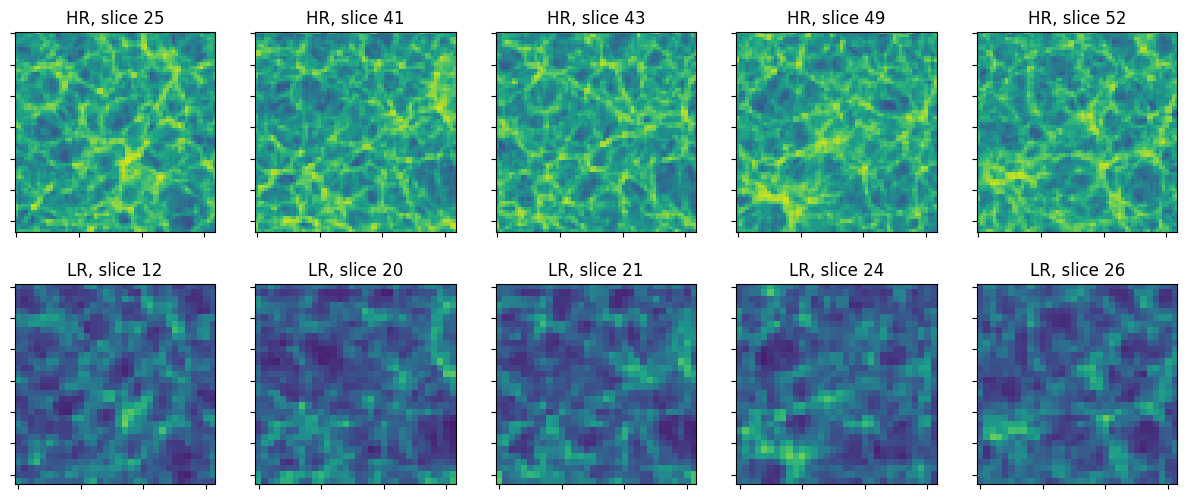

In [30]:
fig, ax = plt.subplots(2,display_num, figsize=(display_num * 3, 6))
for i in range(display_num):
    im = ax[0,i].imshow(data_input[:1].squeeze(0).squeeze(0).cpu().numpy()[random_idx[i]], vmin=0.5, vmax=1)
    ax[0,i].set_xticklabels([])
    ax[0,i].set_yticklabels([])
    ax[0,i].set_title("HR, slice {}".format(random_idx[i]))
    #fig.colorbar(im, ax=ax[0,i]) if i == 0 else None

    im = ax[1,i].imshow(data_cond[:1].squeeze(0).squeeze(0).cpu().numpy()[random_idx[i]//2], vmin=0.5, vmax=1)
    ax[1,i].set_xticklabels([])
    ax[1,i].set_yticklabels([])
    ax[1,i].set_title("LR, slice {}".format(random_idx[i]//2))
    #fig.colorbar(im, ax=ax[1,i]) if i == 0 else None

In [31]:
tmp_cond = data_cond[:1].to(device)
timesteps = params["diffusion"]["timesteps"]
#save_step = 100
save_timesteps = np.array([0, 50, 100, 300, 1000, 1500])

model.eval()
imgs = []
img = torch.randn_like(data_input[:1]).to(device)
for j in tqdm(reversed(range(0, save_timesteps[-1]+1)), desc="sampling", total=save_timesteps[-1]):
    t = torch.full((tmp_cond.shape[0],), j, device=device, dtype=torch.long)
    img = model.diffusion.p_sample(model.model, img, t, j, condition=tmp_cond)
    if (j in save_timesteps):
        #print("Current step: {}".format(j))
        imgs.append(img.detach().cpu().numpy())

sampling:   0%|          | 0/1500 [00:00<?, ?it/s]

sampling:  27%|██▋       | 407/1500 [02:07<06:37,  2.75it/s]

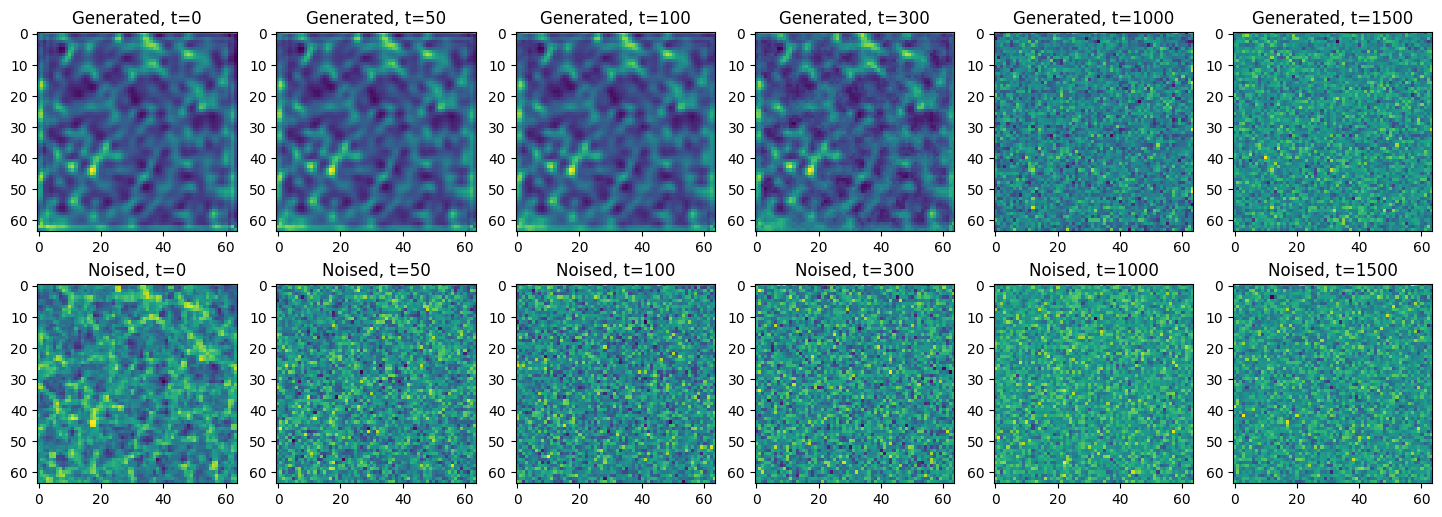

In [ ]:
map_dir = params["train"]["save_dir"] + "../../img/generated"
os.makedirs(map_dir, exist_ok=True)
samples = [model.diffusion.q_sample(data_input[:1].to(device), torch.full((data_input[:1].shape[0],), j, device=device, dtype=torch.long)) for j in save_timesteps]

num_imgs = len(save_timesteps)
fig, ax = plt.subplots(2, num_imgs, figsize=(num_imgs*3, 6))
for i in range(num_imgs):
    ax[0, i].imshow(imgs[-(i+1)].squeeze(0).squeeze(0)[0])
    ax[0, i].set_title("Generated, t={}".format(save_timesteps[i]))

    ax[1, i].imshow(samples[i].squeeze(0).squeeze(0).cpu().numpy()[0])
    ax[1, i].set_title("Noised, t={}".format(save_timesteps[i]))
plt.show()

In [16]:
cond_upsample = model.model.cond_upsample(tmp_cond[:1])

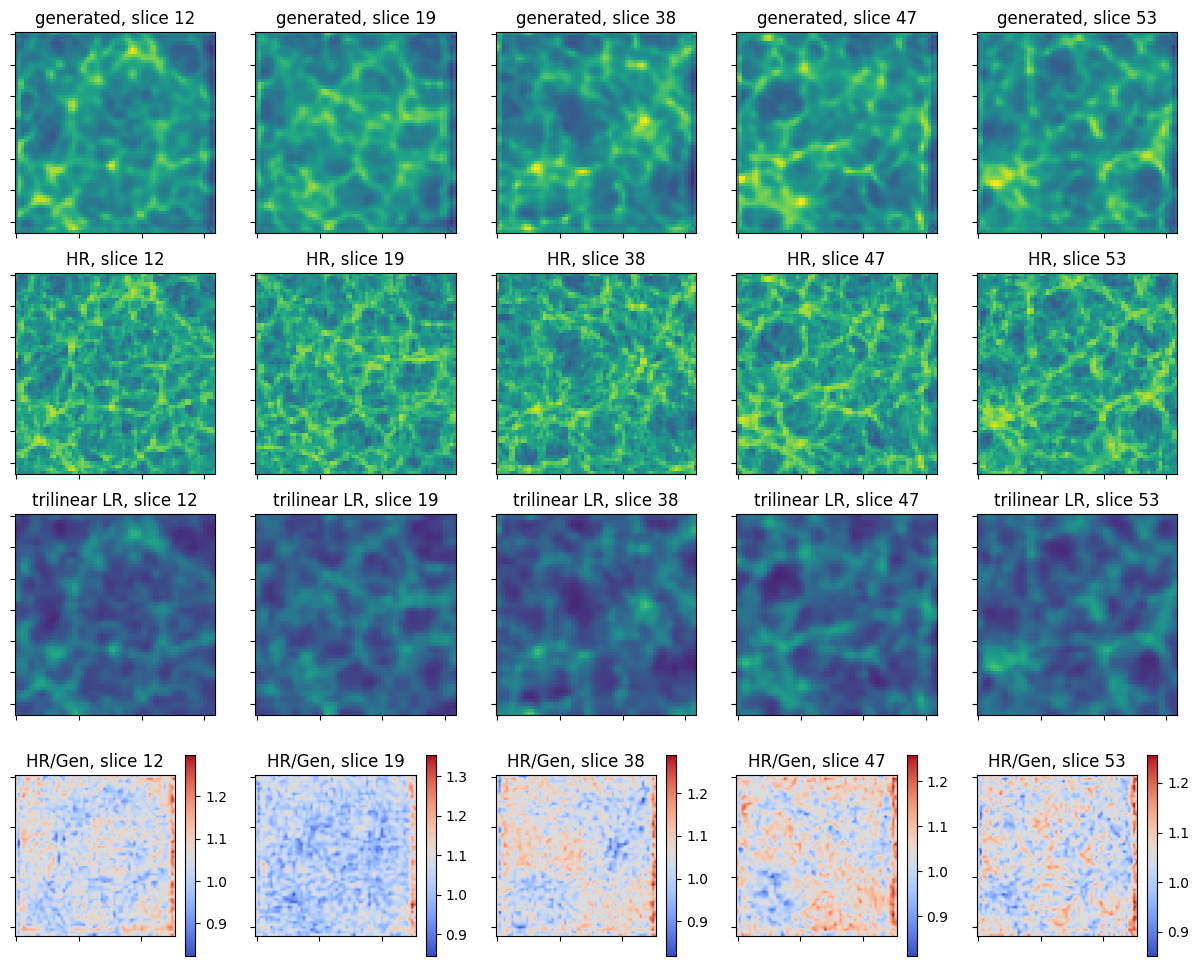

In [17]:
fig, ax = plt.subplots(4,display_num, figsize=(display_num * 3, 12))
for i in range(display_num):
    # plot with colorbar
    im = ax[0,i].imshow(imgs[-1][0, 0, random_idx[i], :, :], vmin=0.5, vmax=1)
    ax[0,i].set_xticklabels([])
    ax[0,i].set_yticklabels([])
    ax[0,i].set_title("generated, slice {}".format(random_idx[i]))
    #fig.colorbar(im, ax=ax[0,i])
    
    im = ax[1,i].imshow(data_input[:1].squeeze(0).squeeze(0).cpu().numpy()[random_idx[i]], vmin=0.5, vmax=1)
    ax[1,i].set_xticklabels([])
    ax[1,i].set_yticklabels([])
    ax[1,i].set_title("HR, slice {}".format(random_idx[i]))
    #fig.colorbar(im, ax=ax[1,i])

    im = ax[2,i].imshow(cond_upsample.squeeze(0).squeeze(0).cpu().numpy()[random_idx[i]], vmin=0.5, vmax=1)
    ax[2,i].set_xticklabels([])
    ax[2,i].set_yticklabels([])
    ax[2,i].set_title("trilinear LR, slice {}".format(random_idx[i]))
    #fig.colorbar(im, ax=ax[2,i])

    im = ax[3,i].imshow((data_input[:1]/imgs[-1]).squeeze(0).squeeze(0).cpu().numpy()[random_idx[i]],  cmap='coolwarm')
    ax[3,i].set_xticklabels([])
    ax[3,i].set_yticklabels([])
    ax[3,i].set_title("HR/Gen, slice {}".format(random_idx[i]))
    fig.colorbar(im, ax=ax[3,i])
plt.show()

In [76]:
from scripts.utils.diffusion_utils import get_masked_grid

In [82]:
def grid_chunk(x):
        batch, channel, height, width, depth = x.shape
        subbox = [torch.Tensor(x[:,:,i*height//2:(i+1)*height//2,j*width//2:(j+1)*width//2,k*depth//2:(k+1)*depth//2]) 
                for i in range(2) for j in range(2) for k in range(2)]
        return subbox

def grid_unchunk(subbox):
    batch, channel, height, width, depth = subbox[0].shape
    x = torch.zeros((batch, channel, height*2, width*2, depth*2), device=subbox[0].device)

    for i in range(2):
        for j in range(2):
            for k in range(2):
                x[:,:,i*height:(i+1)*height,j*width:(j+1)*width,k*depth:(k+1)*depth] = subbox[i*4 + j*2 + k]
    return x

def get_masked_grid(x, mask=None, x_t=None):
    subbox = grid_chunk(x)
    if mask is None:
        mask = np.ones(8)
    if x_t is None:
        x_t = torch.randn_like(x)
    x_t = grid_chunk(x_t)
    x = [x_t[i] if mask[i] else subbox[i] for i in range(8)]
    x = grid_unchunk(x)
    return x

In [83]:
mask = [1, 0, 0, 0, 1, 0, 0, 0]
x = get_masked_grid(torch.Tensor(imgs[-1]), mask)

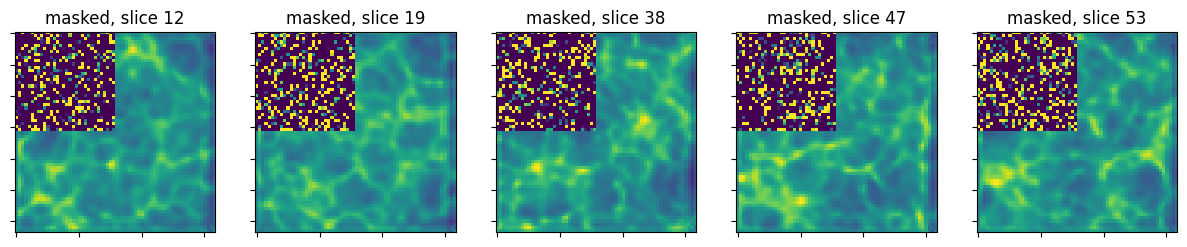

In [84]:
fig, ax = plt.subplots(1,display_num, figsize=(display_num * 3, 3))
for i in range(display_num):
    # plot with colorbar
    im = ax[i].imshow(x[0, 0, random_idx[i], :, :], vmin=0.5, vmax=1)
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].set_title("masked, slice {}".format(random_idx[i]))
plt.show()

In [85]:
model.eval()
img_ups = []
img = x.to(device)

model.eval()
for j in tqdm(reversed(range(0, save_timesteps[-1]+1)), desc="sampling", total=save_timesteps[-1]):
    t = torch.full((tmp_cond.shape[0],), j, device=device, dtype=torch.long)
    img = model.diffusion.p_sample(model.model, img, t, j, condition=tmp_cond)
    img = get_masked_grid(x, mask, img)
    if (j in save_timesteps):
        #print("Current step: {}".format(j))
        img_ups.append(img.detach().cpu().numpy())

sampling: 1501it [06:40,  3.75it/s]                          


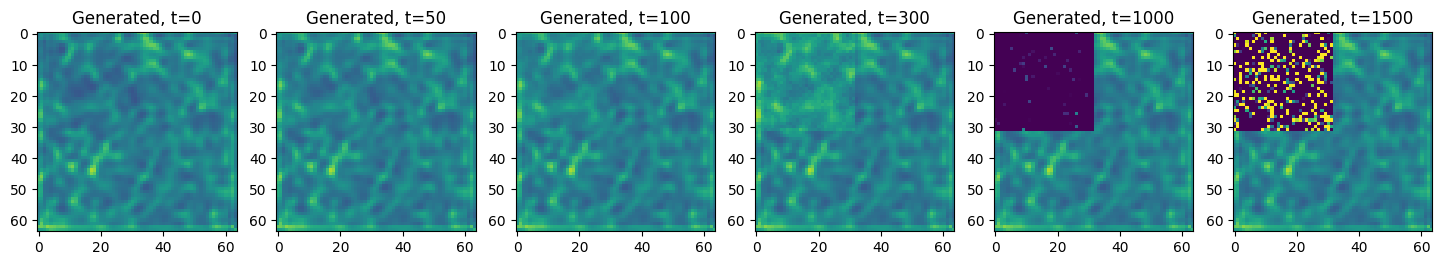

In [86]:
fig, ax = plt.subplots(1, num_imgs, figsize=(num_imgs*3, 6))
for i in range(num_imgs):
    ax[i].imshow(img_ups[-(i+1)].squeeze(0).squeeze(0)[0], vmin=0.5, vmax=1)
    ax[i].set_title("Generated, t={}".format(save_timesteps[i]))

In [87]:
mask = [1, 1, 0, 0, 1, 1, 0, 0]
x = get_masked_grid(torch.Tensor(imgs[-1]), mask)

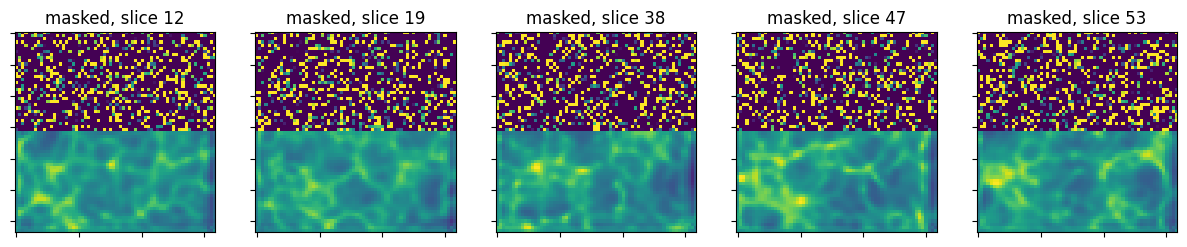

In [88]:
fig, ax = plt.subplots(1,display_num, figsize=(display_num * 3, 3))
for i in range(display_num):
    # plot with colorbar
    im = ax[i].imshow(x[0, 0, random_idx[i], :, :], vmin=0.5, vmax=1)
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].set_title("masked, slice {}".format(random_idx[i]))
plt.show()

In [89]:
model.eval()
img_ups = []
img = x.to(device)

model.eval()
for j in tqdm(reversed(range(0, save_timesteps[-1]+1)), desc="sampling", total=save_timesteps[-1]):
    t = torch.full((tmp_cond.shape[0],), j, device=device, dtype=torch.long)
    img = model.diffusion.p_sample(model.model, img, t, j, condition=tmp_cond)
    img = get_masked_grid(x, mask, img)
    if (j in save_timesteps):
        #print("Current step: {}".format(j))
        img_ups.append(img.detach().cpu().numpy())

sampling: 1501it [06:36,  3.79it/s]                          


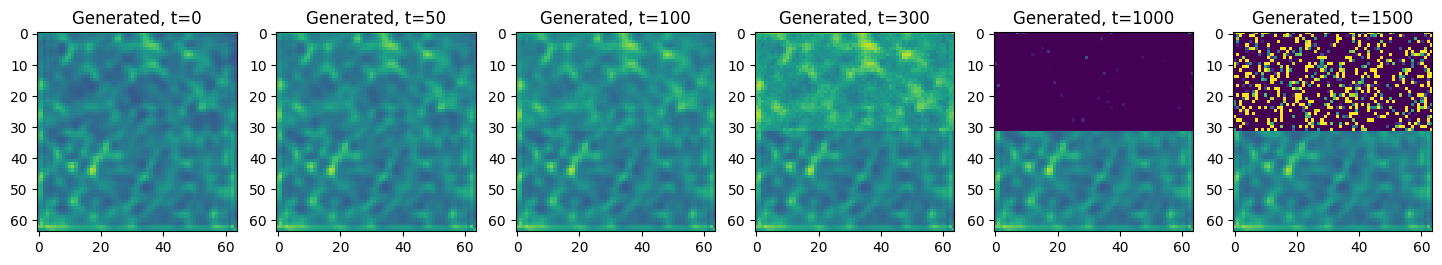

In [90]:
fig, ax = plt.subplots(1, num_imgs, figsize=(num_imgs*3, 6))
for i in range(num_imgs):
    ax[i].imshow(img_ups[-(i+1)].squeeze(0).squeeze(0)[0], vmin=0.5, vmax=1)
    ax[i].set_title("Generated, t={}".format(save_timesteps[i]))